In [1]:
## Import packages

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# function for displaying eta_squared as measure of effect size in ANOVA

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

In [3]:
# Define function for calculating reliability (https://stackoverflow.com/questions/20799403/improving-performance-of-cronbach-alpha-code-python-numpy)

def CronbachAlpha(itemscores):
    # cols are items, rows are observations
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

# Analyzing responsibility data from first studies from summer term 2019


In [2]:
# read file into pd dataframe

data = pd.read_csv(r'responsibility_data_sampled.csv', sep=";")
print(data.shape)
data.head()

(349, 44)


,OID,file_origin,Design,Level,Design_coded,Level_coded,TRUST,DOMINANCE,RHTRUST,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Income,MC_autonom,MC_babyface,MC_baseline,MC_aggressive,MC_wide,Trust_1,Trust_2,Trust_3,RH_Trust_1,RH_Trust_2,RH_Trust_3,RH_Trust_4,RH_Trust_5,RH_Trust_6,RH_Trust_7,RH_Trust_8,RH_Trust_9,Dominance_1,Dominance_2,Dominance_3,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5
0,1,Resp_Aggr_LP,1,1,aggressive,level 5,333.333.333.333.333,466.666.666.666.667,533.333.333.333.333,7,1,3,1,female,24,2,400,5,1,11,2,3,6,4,3,4,3,6,3,4,6,6,6,6,5,6,4,5,5,7,4,6,6,1
1,2,Resp_Aggr_LP,1,0,aggressive,level 3,5,4,522.222.222.222.222,2,4,7,5,female,29,2,2000,5,1,6,1,4,1,3,5,5,5,5,5,5,5,6,4,6,6,5,4,1,7,6,2,7,7,1
2,4,Resp_Aggr_LP,1,1,aggressive,level 5,666.666.666.666.667,433.333.333.333.333,666.666.666.666.667,5,3,6,4,male,19,2,5000,5,1,8,3,2,3,3,7,7,6,7,7,7,7,7,5,7,6,7,5,3,5,7,6,7,6,1
3,5,Resp_Aggr_LP,0,0,baseline,level 3,466.666.666.666.667,333.333.333.333.333,411.111.111.111.111,6,4,6,6,male,50,1,40000,5,0,10,3,6,2,3,4,5,5,5,4,4,4,4,4,4,4,4,2,2,6,6,2,6,6,1
4,6,Resp_Aggr_LP,0,0,baseline,level 3,233.333.333.333.333,466.666.666.666.667,488.888.888.888.889,1,1,7,4,male,21,2,300,5,1,6,5,6,5,5,1,5,1,5,5,6,7,4,1,5,5,6,3,4,7,5,4,7,6,1


In [3]:
print(data['Design'].value_counts().sort_index())
print(data['Level'].value_counts().sort_index())

0    96
1    90
2    79
3    84
Name: Design, dtype: int64
0    180
1    169
Name: Level, dtype: int64


In [4]:
# Delete "Wide"-condition

#annotation Design:
#0 = baseline
#1 = aggressive
#2 = babyfaced
#3 = wide

data = data[data['Design'] < 3]
data.shape

(265, 44)

In [5]:
data.columns

Index(['OID', 'file_origin', 'Design', 'Level', 'Design_coded', 'Level_coded',
       'TRUST', 'DOMINANCE', 'RHTRUST', 'Resp_Bic', 'Resp_Car', 'Resp_Driver',
       'Resp_Producer', 'Sex', 'Age', 'Car_Owner', 'km_year', 'Education',
       'Income', 'MC_autonom', 'MC_babyface', 'MC_baseline', 'MC_aggressive',
       'MC_wide', 'Trust_1', 'Trust_2', 'Trust_3', 'RH_Trust_1', 'RH_Trust_2',
       'RH_Trust_3', 'RH_Trust_4', 'RH_Trust_5', 'RH_Trust_6', 'RH_Trust_7',
       'RH_Trust_8', 'RH_Trust_9', 'Dominance_1', 'Dominance_2', 'Dominance_3',
       'Quality_1', 'Quality_2', 'Quality_3', 'Quality_4', 'Quality_5'],
      dtype='object')

In [7]:
# Two-factorial ANOVA with Design and Level as Factors and Resp_Bic, Resp_Car, Resp_Driver, Resp_Producer as Outcomes



for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    formula = '{} ~ C(Level) + C(Design) + C(Level):C(Design)'.format(resp)
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared(aov_table)
    print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
    print('\n')

ANOVA on Resp_Bic
                       sum_sq     df       F  PR(>F)  eta_sq
C(Level)              0.3522    1.0  0.1351  0.7135  0.0005
C(Design)            36.9327    2.0  7.0803  0.0010  0.0516
C(Level):C(Design)    2.9699    2.0  0.5694  0.5666  0.0041
Residual            675.5045  259.0     NaN     NaN     NaN


ANOVA on Resp_Car
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)             73.3199    1.0  25.9064  0.0000  0.0837
C(Design)            30.1282    2.0   5.3227  0.0054  0.0344
C(Level):C(Design)   39.4793    2.0   6.9747  0.0011  0.0451
Residual            733.0181  259.0      NaN     NaN     NaN


ANOVA on Resp_Driver
                       sum_sq     df        F  PR(>F)  eta_sq
C(Level)            228.1990    1.0  77.0822  0.0000  0.2054
C(Design)            70.1700    2.0  11.8512  0.0000  0.0632
C(Level):C(Design)   46.0212    2.0   7.7726  0.0005  0.0414
Residual            766.7604  259.0      NaN     NaN     NaN


ANOVA on Resp_Producer
 

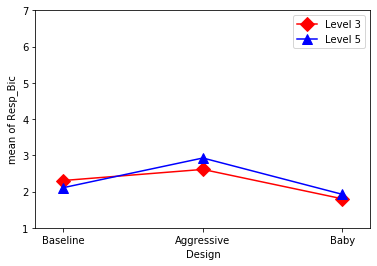

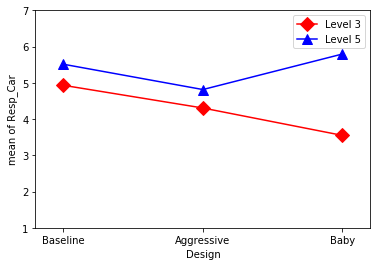

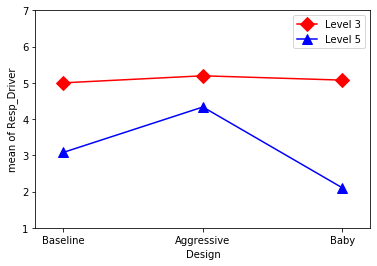

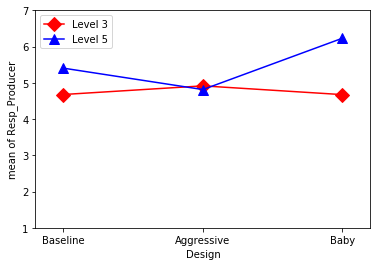

In [8]:
# Visualizing factorial data with statsmodel interaction_plot

for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:

    fig = interaction_plot(data['Design'], data['Level'], data[resp],
                       colors=['red','blue'], markers=['D','^'], ms=10)

    plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
    plt.ylim(1,7)
    plt.legend(['Level 3', 'Level 5'])
    plt.show()


In [9]:
#Post-hoc testing of mean differences for different levels of automation

# display mean values and std. deviations by level and design

means_by_cond = pd.pivot_table(data, 
                               values=['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer'], 
                               index=['Level', 'Design'], aggfunc=[np.mean, np.std])
means_by_cond

mean                                           std  \
              Resp_Bic  Resp_Car Resp_Driver Resp_Producer  Resp_Bic   
Level Design                                                           
0     0       2.305085  4.932203    5.000000      4.677966  1.694354   
      1       2.611111  4.305556    5.194444      4.916667  1.678056   
      2       1.800000  3.550000    5.075000      4.675000  1.604481   
1     0       2.108108  5.513514    3.081081      5.405405  1.307750   
      1       2.925926  4.814815    4.333333      4.814815  1.702959   
      2       1.923077  5.794872    2.102564      6.230769  1.579217   

                                                  
              Resp_Car Resp_Driver Resp_Producer  
Level Design                                      
0     0       1.720710    1.473911      1.467354  
      1       2.011672    1.753681      1.841971  
      2       1.153590    1.491643      1.542351  
1     0       1.574477    1.934746      1.739404  
      1       1.972204    2.009412      1.853849  
      2       1.379922    1.602545      1.346761

In [10]:
#Levene's test vor variance equality

W, p = stats.levene(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])

print('Levene test statistic: {}, p = {}'.format(W, p))


Levene test statistic: 0.17358043213787364, p = 0.6779092066506753


In [11]:
#t-test

t, p = stats.ttest_ind(data[(data['Level']==0) & (data['Design']==0)]['Resp_Bic'], data[(data['Level']==0) & (data['Design']==1)]['Resp_Bic'])
print('t-value = {}, p = {}'.format(t, p))

t-value = -0.8571175223825969, p = 0.3935832632918522


In [12]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
    for level in sorted(data['Level'].unique()):
        print('\nT-tests for {} on automation level {}'.format(resp, level))
        values = data[data['Level']==level][['Design', resp]]
        for design in sorted(data['Design'].unique()):
            if design == 2:
                one = 0
                two = 2
            else:
                one = design
                two = design+1
            
            if stats.levene(values[values['Design']==one][resp], values[values['Design']==two][resp])[1] < .05:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp], equal_var=False)
            else:
                t, p = stats.ttest_ind(values[values['Design']==one][resp], values[values['Design']==two][resp])
            print('Comparing means of {} and {}: t-value = {}, p = {}'.format(one, two, round(t,4), round(p,4)))


T-tests for Resp_Bic on automation level 0
Comparing means of 0 and 1: t-value = -0.8571, p = 0.3936
Comparing means of 1 and 2: t-value = 2.1532, p = 0.0346
Comparing means of 0 and 2: t-value = 1.4866, p = 0.1404

T-tests for Resp_Bic on automation level 1
Comparing means of 0 and 1: t-value = -2.5871, p = 0.0113
Comparing means of 1 and 2: t-value = 2.888, p = 0.0048
Comparing means of 0 and 2: t-value = 0.5547, p = 0.5808

T-tests for Resp_Car on automation level 0
Comparing means of 0 and 1: t-value = 1.6142, p = 0.1099
Comparing means of 1 and 2: t-value = 1.9795, p = 0.0528
Comparing means of 0 and 2: t-value = 4.4446, p = 0.0

T-tests for Resp_Car on automation level 1
Comparing means of 0 and 1: t-value = 1.7971, p = 0.0757
Comparing means of 1 and 2: t-value = -2.8192, p = 0.0059
Comparing means of 0 and 2: t-value = -0.8296, p = 0.4094

T-tests for Resp_Driver on automation level 0
Comparing means of 0 and 1: t-value = -0.5561, p = 0.58
Comparing means of 1 and 2: t-value =

# Analyzing design pretest

In [13]:
pretest = pd.read_csv('pretest.csv', sep=";")

pretest.head()

,child,ordi,aggre,domi,wide,narrow,relia,trust,age,sex,grad,owner,interest,type,no
0,1.0,6,2,2.0,3,3,5.0,6.0,23,0,0.0,0,4,1,14
1,5.0,7,3,4.0,5,2,2.0,2.0,25,1,1.0,1,2,1,1
2,3.0,3,4,5.0,5,1,7.0,5.0,22,0,0.0,0,4,2,14
3,3.0,6,3,3.0,3,3,5.0,4.0,21,1,0.0,0,4,3,14
4,2.0,5,3,3.0,3,5,4.0,4.0,26,1,1.0,0,4,2,1


In [14]:
pretest.shape

(135, 15)

In [15]:
#Annotation design
#1 = baseline
#2 = wide
#3 = aggressive
#4 = childish
#5 = aggressive2


In [16]:
#delete wide condition

pretest = pretest[pretest['type'] != 2]
pretest.shape

(108, 15)

In [17]:
#Visualize mean values by condition
pretest.columns

Index(['child', 'ordi', 'aggre', 'domi', 'wide', 'narrow', 'relia', 'trust',
       'age', 'sex', 'grad', 'owner', 'interest', 'type', 'no'],
      dtype='object')

In [18]:
means_by_cond = pd.pivot_table(pretest, values=['child', 'ordi', 'aggre'], index=['type'])

means_by_cond = means_by_cond.reset_index()
means_by_cond

,type,aggre,child,ordi
0,1,2.518519,2.814815,4.629630
1,3,3.074074,2.888889,3.851852
2,4,1.518519,4.222222,3.074074
3,5,3.481481,2.538462,3.888889


In [19]:
means = means_by_cond[['aggre', 'child', 'ordi']].T
means

,0,1,2,3
aggre,2.518519,3.074074,1.518519,3.481481
child,2.814815,2.888889,4.222222,2.538462
ordi,4.629630,3.851852,3.074074,3.888889


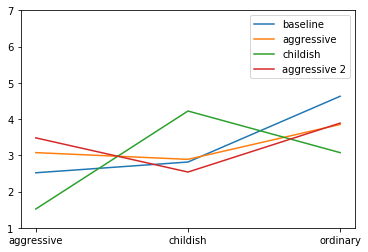

In [20]:
plt.plot(means[0])
plt.plot(means[1])
plt.plot(means[2])
plt.plot(means[3])

plt.legend(['baseline', 'aggressive', 'childish', 'aggressive 2'])
plt.xticks([0,1,2], labels=['aggressive', 'childish', 'ordinary'])
plt.ylim(1,7)

plt.show()

In [21]:
# t-tests for evaluating mean differences on perceptions

#Annotation type
#1 = baseline
#3 = aggressive
#4 = childish
#5 = aggressive2

design = {1:'baseline', 3:'aggressive', 4:'childish', 5:'aggressive 2'}

for perception in ['ordi', 'child', 'aggre']: 
    print('T-tests for {}'.format(perception)+'\n')
    for i in [3,4,5]:
        t, p = stats.ttest_ind(pretest[pretest['type']==1][perception], pretest[pretest['type']==i][perception], nan_policy='omit')
        print('Mean difference between baseline and {}: t = {}, p = {}'.format(design[i], t, p)+'\n\n')
    

T-tests for ordi

Mean difference between baseline and aggressive: t = 1.852817889523018, p = 0.06958725159986436


Mean difference between baseline and childish: t = 3.927041422953478, p = 0.0002544372463183222


Mean difference between baseline and aggressive 2: t = 1.7844672401846167, p = 0.08018223508460963


T-tests for child

Mean difference between baseline and aggressive: t = -0.180108790857026, p = 0.8577672258519458


Mean difference between baseline and childish: t = -3.5119469462795507, p = 0.0009291342693225183


Mean difference between baseline and aggressive 2: t = 0.6653512781265521, p = 0.5088238259070088


T-tests for aggre

Mean difference between baseline and aggressive: t = -1.3082534956552148, p = 0.1965408378946408


Mean difference between baseline and childish: t = 2.971909493767028, p = 0.00447432442754741


Mean difference between baseline and aggressive 2: t = -2.0203332399313667, p = 0.048513597564308335




# Analyzing responsibility data from winter term 2019/2020

## Data from Hildebrand and Bitzer

In [39]:
#Create pandas dataframe from Hildebrand
data1 = pd.read_csv(r'2019-11-11_Hildebrand.csv', sep=";")
print(data1.shape)
data1.head()

(169, 87)


,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,Studienteilnahme,Trust_Car_1,Trust_Car_2,Trust_Car_3,car_check,Manip_Check_1,Manip_Check_2,Manip_Check_3,car_comp1,car_comp2,car_comp3,car_comp4,car_comp5,car_consc1,car_consc2,car_consc3,car_consc4,car_consc5,car_consc6,driv_comp1,driv_comp2,driv_comp3,driv_comp4,driv_comp5,driv_consc1,driv_consc2,driv_consc3,driv_consc4,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Occupation,Occupation_Sonst,Income,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5,Quality_6,ext_host,ip_addr,browser,referer,device_type,participant_browser,participant_browser_version,participant_os,participant_device,participant_brand,participant_model,participant_isbot,participant_continent,participant_country,participant_region,participant_city,participant_latitude,participant_longitude,quota,quota_assignment,page_history,hflip,vflip,output_mode,javascript,flash,session_id,language,cleaned,ats,datetime,date_of_last_access,date_of_first_mail
0,19,0,0,31,3878440,-77,1349,1,1,2,3,5,9,6,7,3,7,7,6,6,6,7,7,6,7,4,4,7,7,7,7,7,6,6,6,6,4,4,4,6,1,25,1,300,5,7,-99,1,7,1,7,7,1,7,-99,-99,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,1,0,-77,-77,02cbd320b7bc4ae302f2023c59d8568b,1,0,1571666104,2019-10-21 13:55:04,2019-10-21 14:17:33,0000-00-00 00:00:00
1,20,0,0,31,3878440,-77,313,5,1,3,2,4,9,5,2,2,5,4,4,6,6,6,5,3,5,6,5,4,5,4,6,4,5,6,4,4,2,5,3,6,2,24,2,3000,5,7,-99,1,6,2,7,5,1,7,-99,-99,Mozilla/5.0 (Linux; Android 7.1.1; SM-J510FN) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,0,0,-77,-77,4fa76bfa326ad0959a35c42e24ea9868,1,0,1571666548,2019-10-21 14:02:28,2019-10-21 14:07:41,0000-00-00 00:00:00
2,34,0,0,31,3878440,-77,490,2,1,1,2,6,3,7,5,1,2,2,3,2,4,4,4,4,4,4,4,1,2,2,2,2,4,5,6,5,1,3,7,2,1,27,2,15000,5,7,-99,1,5,2,7,7,1,7,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_2 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878436,387843...",0,0,0,-77,-77,6ffc04c53315dab2eec67dd81fed8813,1,0,1571668222,2019-10-21 14:30:22,2019-10-21 14:38:32,0000-00-00 00:00:00
3,39,0,0,31,3878440,-77,1038,4,1,4,4,4,10,4,5,3,5,4,3,4,3,1,1,1,1,1,1,4,4,4,3,4,4,5,4,4,5,4,5,4,2,25,1,18000,5,7,-99,1,4,1,7,7,1,7,-99,-99,Mozilla/5.0 (Linux; Android 8.0.0; RNE-L21) Ap...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",1,1,0,-77,-77,1d592b69c88664ecb52b22cd35cbdd2b,1,0,1571669406,2019-10-21 14:50:06,2019-10-21 15:07:24,0000-00-00 00:00:00
4,43,0,0,31,3878440,-77,345,1,1,3,7,6,5,6,5,1,7,6,6,6,6,2,3,3,4,3,3,6,5,5,6,6,3,5,2,2,2,7,6,7,2,22,1,20000,5,1,-99,1,2,6,6,7,1,7,-99,-99,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14) ...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3878430,3878432,3878435,3878436,3878437,387843...",0,1,0,-77,-77,75c855a9f4d5b9c198ae5bedf34baff7,1,0,1571669892,2019-10-21 14:58:12,2019-10-21 15:03:57,0000-00-00 00:00:00


In [40]:
#Create pandas dataframe from Bitzer
data2 = pd.read_csv(r'2019-11-11_Bitzer.csv', sep=";")
print(data2.shape)
data2.head()

(75, 87)


,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,Studienteilnahme,Trust_Car_1,Trust_Car_2,Trust_Car_3,car_check,Manip_Check_1,Manip_Check_2,Manip_Check_3,car_comp1,car_comp2,car_comp3,car_comp4,car_comp5,car_consc1,car_consc2,car_consc3,car_consc4,car_consc5,car_consc6,driv_comp1,driv_comp2,driv_comp3,driv_comp4,driv_comp5,driv_consc1,driv_consc2,driv_consc3,driv_consc4,Resp_Bic,Resp_Car,Resp_Driver,Resp_Producer,Sex,Age,Car_Owner,km_year,Education,Occupation,Occupation_Sonst,Income,Quality_1,Quality_2,Quality_3,Quality_4,Quality_5,Quality_6,ext_host,ip_addr,browser,referer,device_type,participant_browser,participant_browser_version,participant_os,participant_device,participant_brand,participant_model,participant_isbot,participant_continent,participant_country,participant_region,participant_city,participant_latitude,participant_longitude,quota,quota_assignment,page_history,hflip,vflip,output_mode,javascript,flash,session_id,language,cleaned,ats,datetime,date_of_last_access,date_of_first_mail
0,24,0,0,31,3884111,-77,740,6,1,4,5,5,6,1,3,1,5,5,6,4,4,4,7,4,6,4,4,2,3,1,1,1,6,7,6,7,4,4,4,7,1,24,2,2500,3,2,-99,2,7,1,7,5,1,5,-99,-99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",0,0,0,-77,-77,fe9756107d066e90dc0d668b0af554cf,1,0,1571731288,2019-10-22 08:01:28,2019-10-22 08:13:48,0000-00-00 00:00:00
1,26,0,0,31,3884111,-77,626,2,1,1,1,6,9,5,5,5,4,4,4,5,5,4,4,5,3,4,4,2,3,3,3,2,6,6,4,7,3,7,2,6,1,24,2,500,3,2,-99,2,1,3,7,7,1,7,-99,-99,Mozilla/5.0 (Linux; Android 8.1.0; SM-T580) Ap...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,1,0,-77,-77,57c055cbbf4eaee831f3723a9d5d6bf8,1,0,1571731316,2019-10-22 08:01:56,2019-10-22 08:12:22,0000-00-00 00:00:00
2,27,0,0,31,3884111,-77,418,5,1,1,2,3,10,7,2,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,2,6,6,6,1,30,1,15000,5,7,-99,4,7,1,7,7,1,5,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 13_1_3 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",0,1,0,-77,-77,d26905c9aa7d9f07c3cb888cb85e42e5,1,0,1571732685,2019-10-22 08:24:45,2019-10-22 08:31:43,0000-00-00 00:00:00
3,28,0,0,31,3884111,-77,427,4,1,3,5,5,9,1,3,4,5,5,4,3,4,4,3,5,5,6,4,6,5,5,5,5,6,6,5,7,5,6,6,6,2,25,1,7000,5,7,-99,3,7,2,7,4,1,7,-99,-99,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,0,0,-77,-77,fbc2b61f0172bc712f8eae206f39d50e,1,0,1571735804,2019-10-22 09:16:44,2019-10-22 09:23:51,0000-00-00 00:00:00
4,29,0,0,32,3884111,-77,-1,1,1,4,3,4,8,2,3,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,5,4,2,5,4,5,1,30,1,10000,5,7,-99,4,4,6,5,4,1,6,-99,-99,Mozilla/5.0 (iPhone; CPU iPhone OS 12_4_1 like...,-99,0,0,-99,0,0,0,0,0,0,0,-99,-99,-66,-66,0,-66,"3884104,3884105,3884106,3884107,3884108,388410...",1,0,0,-77,-77,d5a4363cea69124f5fc104afa8455db6,1,0,1571739442,2019-10-22 10:17:22,2019-10-22 12:14:05,0000-00-00 00:00:00


In [41]:
#Merge dataframes

data = pd.concat([data1, data2], ignore_index=True)
data.shape

(244, 87)

In [42]:
data.columns

Index(['lfdn', 'external_lfdn', 'tester', 'dispcode', 'lastpage', 'quality',
       'duration', 'c_0001', 'Studienteilnahme', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4', 'Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer',
       'Sex', 'Age', 'Car_Owner', 'km_year', 'Education', 'Occupation',
       'Occupation_Sonst', 'Income', 'Quality_1', 'Quality_2', 'Quality_3',
       'Quality_4', 'Quality_5', 'Quality_6', 'ext_host', 'ip_addr', 'browser',
       'referer', 'device_type', 'participant_browser',
       'participant_browser_version', 'participant_os', 'participant_device',
       'participant_brand'

In [43]:
data1.name = 'Data Hildebrand'
data.name = 'Data merged'

In [44]:
# Cases per experimental condition

for d in [data1, data]:
    print(d.name)
    print(d['c_0001'].value_counts().sort_index())

Data Hildebrand
1    27
2    30
3    28
4    23
5    29
6    32
Name: c_0001, dtype: int64
Data merged
1    41
2    45
3    37
4    34
5    42
6    45
Name: c_0001, dtype: int64


In [46]:
# Drop unnecessary columns
def drop_columns(data):
    data = data.drop(columns=['external_lfdn', 'tester', 'dispcode', 'lastpage', 'quality',
                         'Studienteilnahme', 'ext_host', 'ip_addr', 'browser',
       'referer', 'device_type', 'participant_browser',
       'participant_browser_version', 'participant_os', 'participant_device',
       'participant_brand', 'participant_model', 'participant_isbot',
       'participant_continent', 'participant_country', 'participant_region',
       'participant_city', 'participant_latitude', 'participant_longitude',
       'quota', 'quota_assignment', 'page_history', 'hflip', 'vflip',
       'output_mode', 'javascript', 'flash', 'session_id', 'language',
       'cleaned', 'ats', 'date_of_first_mail']).copy()
    print(data.columns)
    return data

data = drop_columns(data)
data1 = drop_columns(data1)

Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4', 'Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer',
       'Sex', 'Age', 'Car_Owner', 'km_year', 'Education', 'Occupation',
       'Occupation_Sonst', 'Income', 'Quality_1', 'Quality_2', 'Quality_3',
       'Quality_4', 'Quality_5', 'Quality_6', 'datetime',
       'date_of_last_access'],
      dtype='object')
Index(['lfdn', 'duration', 'c_0001', 'Trust_Car_1', 'Trust_Car_2',
       'Trust_Car_3', 'car_check', 'Manip_Check_1', 'Manip_Check_2',
       'Manip_Check_3', 'car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
      

In [47]:
# Compute experimental factor variables

# Labels of c_0001
# 1 = 'Level 3, Baseline'
# 2 = 'Level 3, Baby'
# 3 = 'Level 3, Aggressive'
# 4 = 'Level 5, Baseline'
# 5 = 'Level 5, Baby'
# 6 = 'Level 5, Aggressive'

def factors(data):
    # Creat dictionaries
    level_dictionary ={1 : 'Level 3', 2 : 'Level 3', 3 : 'Level 3', 
                   4 : 'Level 5', 5 : 'Level 5', 6 : 'Level 5'}
    design_dictionary = {1 : 'Baseline', 2 : 'Baby', 3 : 'Aggressive', 
                     4 : 'Baseline', 5 : 'Baby', 6 : 'Aggressive'}
    # Add a new columns
    data['level'] = data['c_0001'].map(level_dictionary).astype('category')
    data['design'] = data['c_0001'].map(design_dictionary)
    data['design'] = pd.Categorical(data['design'], ordered = False, categories = ['Baseline', 'Aggressive', 'Baby']) 
    # Check
    print(data[['c_0001', 'level', 'design']].head())
    return data

data = factors(data)
data1 = factors(data1)

   c_0001    level    design
0       1  Level 3  Baseline
1       5  Level 5      Baby
2       2  Level 3      Baby
3       4  Level 5  Baseline
4       1  Level 3  Baseline
   c_0001    level    design
0       1  Level 3  Baseline
1       5  Level 5      Baby
2       2  Level 3      Baby
3       4  Level 5  Baseline
4       1  Level 3  Baseline


### Check manipulation variables

In [48]:
# Rename manipulationchecks Manip_Check_1 	Manip_Check_2 	Manip_Check_3 	

def check_manip(data):
    data = data.rename(columns={"Manip_Check_1": "childish", "Manip_Check_2": "ordinary", "Manip_Check_3":"aggressive"})
    print(data[['car_check', 'childish', 'ordinary', 'aggressive']].describe()) #check min and max
    print('\nMissing values\n',data[['car_check', 'childish', 'ordinary', 'aggressive']].isna().sum()) #check for missing values
    return data

data = check_manip(data)
data1 = check_manip(data1)

        car_check    childish    ordinary  aggressive
count  244.000000  244.000000  244.000000  244.000000
mean     7.938525    3.213115    4.266393    2.438525
std      2.604268    2.164926    1.865525    1.766256
min      1.000000    1.000000    1.000000    1.000000
25%      6.750000    1.000000    3.000000    1.000000
50%      9.000000    2.000000    5.000000    2.000000
75%     10.000000    5.000000    6.000000    3.000000
max     11.000000    7.000000    7.000000    7.000000

Missing values
 car_check     0
childish      0
ordinary      0
aggressive    0
dtype: int64
        car_check    childish    ordinary  aggressive
count  169.000000  169.000000  169.000000  169.000000
mean     7.994083    3.278107    4.254438    2.390533
std      2.608359    2.192966    1.864549    1.746126
min      1.000000    1.000000    1.000000    1.000000
25%      7.000000    1.000000    3.000000    1.000000
50%      9.000000    3.000000    5.000000    2.000000
75%     10.000000    6.000000    6.000000 

In [53]:
# Manipulation check automation level

def man_check(data):
    if stats.levene(data[data['level']=='Level 3']['car_check'], 
                    data[data['level']=='Level 5']['car_check'])[1] < .05: #check for variance equality
        t, p = stats.ttest_ind(data[data['level']=='Level 3']['car_check'], 
                               data[data['level']=='Level 5']['car_check'], equal_var=False) #t-test with Welch-correction
    else:
        t, p = stats.ttest_ind(data[data['level']=='Level 3']['car_check'], 
                               data[data['level']=='Level 5']['car_check']) #t-test withouth Welch-correction

    print('Comparing means of car_check between {} and {}: t-value = {}, p = {}'.format('Level 3', 'Level 5', round(t,4), round(p,4)))
    print('Mean car_check for Level 3:', round(data[data['level']=='Level 3']['car_check'].mean(),3))
    print('Mean car_check for Level 5:', round(data[data['level']=='Level 5']['car_check'].mean(),3))
    

print('Manipulation check for data Hildebrand\n')
man_check(data1)
print('\nManipulation check for data merged\n')
man_check(data)


Manipulation check for data Hildebrand

Comparing means of car_check between Level 3 and Level 5: t-value = -3.373, p = 0.0009
Mean car_check for Level 3: 7.341
Mean car_check for Level 5: 8.655

Manipulation check for data merged

Comparing means of car_check between Level 3 and Level 5: t-value = -4.8539, p = 0.0
Mean car_check for Level 3: 7.171
Mean car_check for Level 5: 8.719


Design check for data Hildebrand

design      Baseline  Aggressive      Baby
aggressive      2.16    3.516667  1.440678
childish        2.44    1.966667  5.322034
ordinary        5.22    3.883333  3.813559


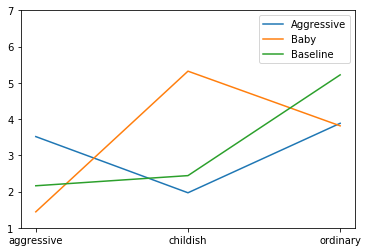


Design check for data merged

design      Baseline  Aggressive      Baby
aggressive  2.400000    3.414634  1.551724
childish    2.320000    1.963415  5.160920
ordinary    5.186667    3.878049  3.839080


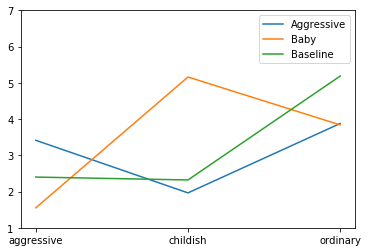

In [54]:
# Display perceptions of design

def design_check(data):
    means_by_cond = pd.pivot_table(data, values=['childish', 'ordinary', 'aggressive'], index=['design'])
    design_means = means_by_cond.T
    print(design_means)
    fig = plt.figure()
    plt.plot(design_means['Aggressive'])
    plt.plot(design_means['Baby'])
    plt.plot(design_means['Baseline'])

    plt.legend(['Aggressive', 'Baby', 'Baseline'])
    plt.xticks([0,1,2], labels=['aggressive', 'childish', 'ordinary'])
    plt.ylim(1,7)

    plt.show()
    
print('Design check for data Hildebrand\n')
design_check(data1)
print('\nDesign check for data merged\n')
design_check(data)
    



In [55]:
# T-tests for manipulation check

def t_test_design(data):
    design = {0:'Baby', 1:'Aggressive'}
    for perception in ['ordinary', 'childish', 'aggressive']: 
        print('T-tests for {}'.format(perception)+'\n')
        for i in design:
            t, p = stats.ttest_ind(data[data['design']=='Baseline'][perception], 
                                   data[data['design']==design[i]][perception], nan_policy='omit')
            print('Mean difference between Baseline and {}: t = {}, p = {}'.format(design[i], round(t,3), round(p,3)),'\n')
            
print('T-tests design for data Hildebrand\n')
t_test_design(data1)
print('\nT-tests design for data merged\n')
t_test_design(data)

T-tests design for data Hildebrand

T-tests for ordinary

Mean difference between Baseline and Baby: t = 4.61, p = 0.0 

Mean difference between Baseline and Aggressive: t = 3.798, p = 0.0 

T-tests for childish

Mean difference between Baseline and Baby: t = -8.708, p = 0.0 

Mean difference between Baseline and Aggressive: t = 1.686, p = 0.095 

T-tests for aggressive

Mean difference between Baseline and Baby: t = 3.405, p = 0.001 

Mean difference between Baseline and Aggressive: t = -4.08, p = 0.0 


T-tests design for data merged

T-tests for ordinary

Mean difference between Baseline and Baby: t = 5.234, p = 0.0 

Mean difference between Baseline and Aggressive: t = 4.559, p = 0.0 

T-tests for childish

Mean difference between Baseline and Baby: t = -10.409, p = 0.0 

Mean difference between Baseline and Aggressive: t = 1.555, p = 0.122 

T-tests for aggressive

Mean difference between Baseline and Baby: t = 3.988, p = 0.0 

Mean difference between Baseline and Aggressive: t = 

## Two-factorial ANOVAS for responsibility attribution 

In [56]:
#check relevant variables

def check_vars(data):
    print(data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']].describe()) #check min and max
    print('\nMissing values\n',data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']].isna().sum()) #check for missing values
    
print('Data Hildebrand\n')
check_vars(data1)

print('\nData merged\n')
check_vars(data)

Data Hildebrand

         Resp_Bic    Resp_Car  Resp_Driver  Resp_Producer
count  169.000000  169.000000   169.000000     169.000000
mean     2.319527    4.662722     4.550296       4.816568
std      1.571217    1.873651     2.143404       1.968976
min      1.000000    1.000000     1.000000       1.000000
25%      1.000000    4.000000     3.000000       4.000000
50%      2.000000    5.000000     5.000000       5.000000
75%      4.000000    6.000000     6.000000       6.000000
max      7.000000    7.000000     7.000000       7.000000

Missing values
 Resp_Bic         0
Resp_Car         0
Resp_Driver      0
Resp_Producer    0
dtype: int64

Data merged

         Resp_Bic    Resp_Car  Resp_Driver  Resp_Producer
count  244.000000  244.000000   244.000000     244.000000
mean     2.463115    4.635246     4.663934       4.959016
std      1.673650    1.931477     2.118353       1.911187
min      1.000000    1.000000     1.000000       1.000000
25%      1.000000    4.000000     3.750000       4.

In [58]:
# Two-factorial ANOVAS

def anova(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        formula = '{} ~ C(level) + C(design) + C(level):C(design)'.format(resp)
        model = ols(formula, data).fit()
        aov_table = anova_lm(model, typ=2)
        eta_squared(aov_table)
        print('ANOVA on {}'.format(resp)+'\n',aov_table.round(4))
        print('\n')
        
print('Data Hildebrand\n')
anova(data1)
print('\nData merged\n')
anova(data)

Data Hildebrand

ANOVA on Resp_Bic
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              1.5626    1.0  0.6278  0.4293  0.0038
C(design)             6.8098    2.0  1.3679  0.2575  0.0164
C(level):C(design)    0.9922    2.0  0.1993  0.8195  0.0024
Residual            405.7303  163.0     NaN     NaN     NaN


ANOVA on Resp_Car
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)             13.3989    1.0  3.9526  0.0485  0.0227
C(design)             5.5709    2.0  0.8217  0.4415  0.0095
C(level):C(design)   17.6360    2.0  2.6013  0.0773  0.0299
Residual            552.5555  163.0     NaN     NaN     NaN


ANOVA on Resp_Driver
                       sum_sq     df        F  PR(>F)  eta_sq
C(level)             87.3068    1.0  21.2162  0.0000  0.1129
C(design)             9.8396    2.0   1.1955  0.3052  0.0127
C(level):C(design)    5.3725    2.0   0.6528  0.5219  0.0069
Residual            670.7604  163.0      NaN     NaN     NaN


ANOVA on Res

ANOVA Plots for data Hildebrand



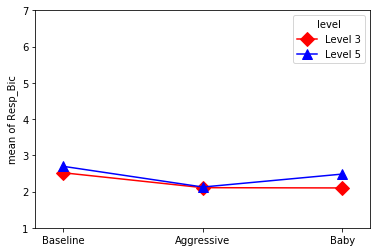

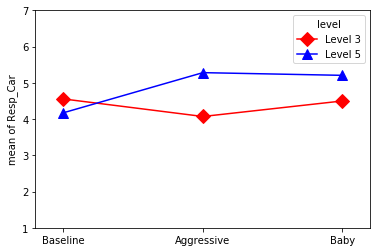

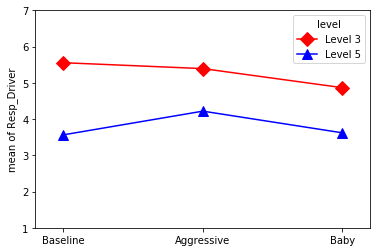

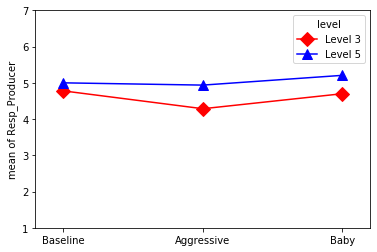

ANOVA Plots for data merged



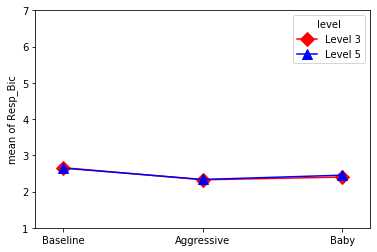

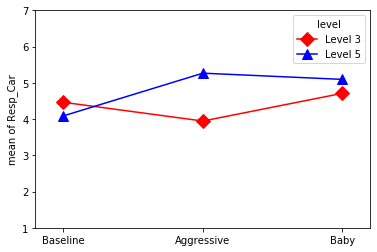

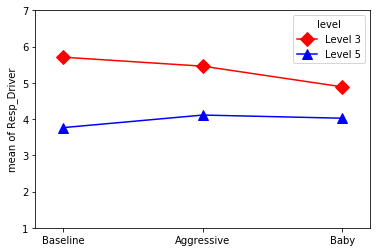

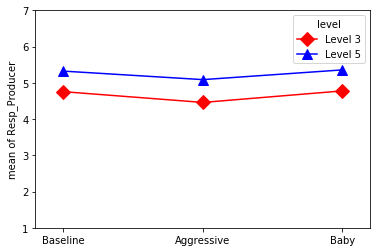

In [59]:
# Visualizing factorial data with statsmodel interaction_plot

def plot(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        fig = interaction_plot(x=data['design'].cat.codes, trace=data['level'], response=data[resp], 
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
        plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
        plt.ylim(1,7)
        plt.show()
        
print('ANOVA Plots for data Hildebrand\n')
plot(data1)
print('ANOVA Plots for data merged\n')
plot(data)

In [62]:
#Post-hoc testing of mean differences for different levels of automation

# display mean values and std. deviations by level and design

def display_means(data):
    print(pd.pivot_table(data, values=['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer'], 
                   index=['level', 'design'], aggfunc=[np.mean, np.std]))
    

print('Means for data Hildebrand\n')
display_means(data1)
print('\nMeans for data merged\n')
display_means(data)

Means for data Hildebrand

                        mean                                           std  \
                    Resp_Bic  Resp_Car Resp_Driver Resp_Producer  Resp_Bic   
level   design                                                               
Level 3 Baseline    2.518519  4.555556    5.555556      4.777778  1.908894   
        Aggressive  2.107143  4.071429    5.392857      4.285714  1.165532   
        Baby        2.100000  4.500000    4.866667      4.700000  1.493665   
Level 5 Baseline    2.695652  4.173913    3.565217      5.000000  1.819960   
        Aggressive  2.125000  5.281250    4.218750      4.937500  1.453583   
        Baby        2.482759  5.206897    3.620690      5.206897  1.595097   

                                                        
                    Resp_Car Resp_Driver Resp_Producer  
level   design                                          
Level 3 Baseline    2.025479    1.527525      1.948043  
        Aggressive  1.631372    1.770944  

In [64]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

def t_tests(data):
    for resp in ['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer']:
        for level in sorted(data['level'].unique()):
            print('\nT-tests for {} on automation level {}'.format(resp, level))
            values = data[data['level']==level][['design', resp]]
            for design in sorted(data['design'].cat.codes.unique()):
                if design == 2:
                    one = 0
                    two = 2
                else:                        
                    one = design
                    two = design+1
            
                if stats.levene(values[values['design'].cat.codes==one][resp], 
                            values[values['design'].cat.codes==two][resp])[1] < .05:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][resp], 
                                       values[values['design'].cat.codes==two][resp], equal_var=False)
                else:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][resp], 
                                       values[values['design'].cat.codes==two][resp])
                print('Comparing means of {} and {}: t-value = {}, p = {}'.format(one, two, round(t,4), round(p,4)))
                

print('T-tests for data Hildebrand\n')
t_tests(data1)
print('\nT-tests for data merged\n')
t_tests(data)

T-tests for data Hildebrand


T-tests for Resp_Bic on automation level Level 3
Comparing means of 0 and 1: t-value = 0.9686, p = 0.3372
Comparing means of 1 and 2: t-value = 0.0202, p = 0.984
Comparing means of 0 and 2: t-value = 0.9266, p = 0.3582

T-tests for Resp_Bic on automation level Level 5
Comparing means of 0 and 1: t-value = 1.292, p = 0.202
Comparing means of 1 and 2: t-value = -0.9166, p = 0.3631
Comparing means of 0 and 2: t-value = 0.4491, p = 0.6553

T-tests for Resp_Car on automation level Level 3
Comparing means of 0 and 1: t-value = 0.978, p = 0.3325
Comparing means of 1 and 2: t-value = -0.8965, p = 0.3738
Comparing means of 0 and 2: t-value = 0.1047, p = 0.917

T-tests for Resp_Car on automation level Level 5
Comparing means of 0 and 1: t-value = -2.1521, p = 0.036
Comparing means of 1 and 2: t-value = 0.1692, p = 0.8662
Comparing means of 0 and 2: t-value = -2.0677, p = 0.0439

T-tests for Resp_Driver on automation level Level 3
Comparing means of 0 and 1: t-value 

## Evaluate effect of design on mediators

In [65]:
def check_vars(data):
    print(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']].describe())

    print(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5', 'car_consc1', 'car_consc2', 'car_consc3', 'car_consc4',
       'car_consc5', 'car_consc6', 'driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5', 'driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']].isnull().sum())
    
print('Data Hildebrand\n')
check_vars(data1)
print('\nData merged\n')
check_vars(data)

Data Hildebrand

        car_comp1   car_comp2   car_comp3   car_comp4   car_comp5  car_consc1  \
count  169.000000  169.000000  169.000000  169.000000  169.000000  169.000000   
mean     4.934911    4.431953    4.550296    4.615385    4.739645    4.195266   
std      1.669552    1.682309    1.606946    1.603567    1.615668    1.813567   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    3.000000    4.000000    4.000000    3.000000   
50%      5.000000    4.000000    5.000000    5.000000    5.000000    4.000000   
75%      6.000000    6.000000    6.000000    6.000000    6.000000    6.000000   
max      7.000000    7.000000    7.000000    7.000000    7.000000    7.000000   

       car_consc2  car_consc3  car_consc4  car_consc5  car_consc6  driv_comp1  \
count  169.000000  169.000000  169.000000  169.000000  169.000000  169.000000   
mean     4.360947    4.130178    4.201183    3.633136    3.650888    4.745562   
std      1

In [66]:
#delete one missing case in driv_consc1

def del_case(data):
    print(data.shape)
    data = data[data['driv_consc1'] > 0]
    print(data.shape)
    return data

data1 = del_case(data1)
data = del_case(data)


(169, 52)
(168, 52)
(244, 52)
(243, 52)


In [67]:
#Check scale reliabilities

def reliability(data):
    print('Reliability of car competence:',CronbachAlpha(data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4',
       'car_comp5']]))
    print('Reliability of car conscientiousness:',CronbachAlpha(data[['car_consc1', 'car_consc2', 'car_consc3', 'car_consc4']]))
    print('Reliability of driver competence:',CronbachAlpha(data[['driv_comp1', 'driv_comp2', 'driv_comp3',
       'driv_comp4', 'driv_comp5']]))
    print('Reliability of driver conscientiousness:',CronbachAlpha(data[['driv_consc1', 'driv_consc2', 'driv_consc3',
       'driv_consc4']]))
    
print('Data Hildebrand')
reliability(data1)
print('\nData merged')
reliability(data)

Data Hildebrand
Reliability of car competence: 0.9426198437331068
Reliability of car conscientiousness: 0.9208798910432178
Reliability of driver competence: 0.9569250565978216
Reliability of driver conscientiousness: 0.9467698929586416

Data merged
Reliability of car competence: 0.929843492062429
Reliability of car conscientiousness: 0.919211458857516
Reliability of driver competence: 0.9531147566134475
Reliability of driver conscientiousness: 0.9391357316623583


In [68]:
# Sufficient reliability, calculate construct measures

def constructs(data):
    data['car_comp'] = data[['car_comp1', 'car_comp2', 'car_comp3', 'car_comp4', 'car_comp5']].mean(axis=1)
    data['car_consc'] = data[['car_consc1', 'car_consc2', 'car_consc3', 'car_consc4']].mean(axis=1)    
    data['driv_comp'] = data[['driv_comp1', 'driv_comp2', 'driv_comp3', 'driv_comp4', 'driv_comp5']].mean(axis=1)
    data['driv_consc'] = data[['driv_consc1', 'driv_consc2', 'driv_consc3', 'driv_consc4']].mean(axis=1)
    print(data[['car_comp', 'car_consc', 'driv_comp', 'driv_consc']].describe())
    return data

print('Data Hildebrand')
data1 = constructs(data1)
print('Data merged')
data = constructs(data)

Data Hildebrand
         car_comp   car_consc   driv_comp  driv_consc
count  168.000000  168.000000  168.000000  168.000000
mean     4.640476    4.205357    4.571429    4.282738
std      1.470600    1.570528    1.567986    1.685745
min      1.000000    1.000000    1.000000    1.000000
25%      3.800000    3.250000    3.400000    3.000000
50%      4.800000    4.250000    4.600000    4.375000
75%      5.800000    5.250000    5.800000    5.562500
max      7.000000    7.000000    7.000000    7.000000
Data merged
         car_comp   car_consc   driv_comp  driv_consc
count  243.000000  243.000000  243.000000  243.000000
mean     4.657613    4.199588    4.545679    4.381687
std      1.425264    1.553049    1.518376    1.608392
min      1.000000    1.000000    1.000000    1.000000
25%      3.800000    3.250000    3.500000    3.250000
50%      4.800000    4.250000    4.600000    4.500000
75%      5.800000    5.250000    5.700000    5.750000
max      7.000000    7.000000    7.000000    7.000000


Data Hildebrand



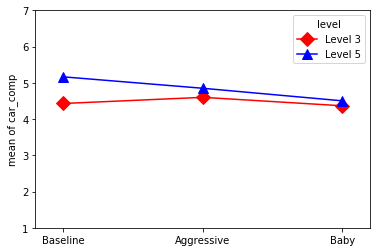

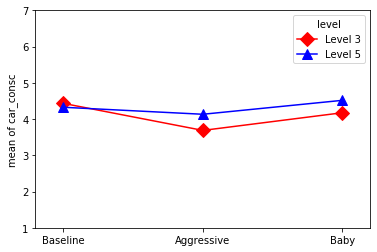

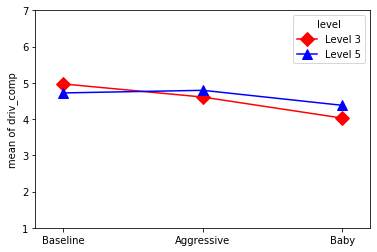

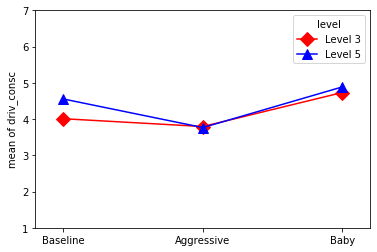


Data merged



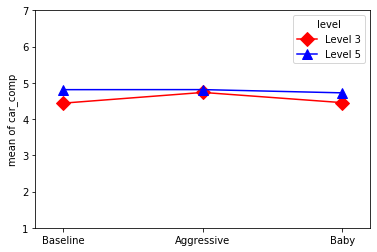

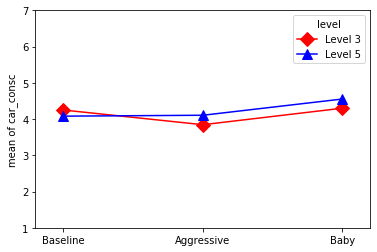

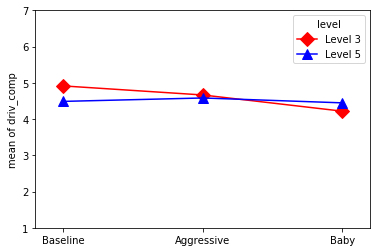

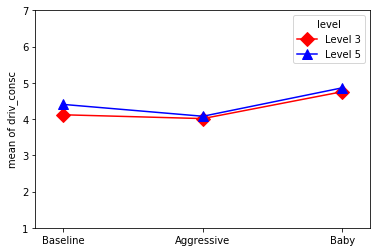

In [70]:
# Illustrate impact of design and automation level on attributions to car and driver

def plot(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        fig = interaction_plot(x=data['design'].cat.codes, trace=data['level'], response=data[attribution], 
                       colors=['red', 'blue'], markers=['D', '^'], ms=10)
        plt.xticks([0,1,2], labels=['Baseline', 'Aggressive', 'Baby'])
        plt.ylim(1,7)
        plt.show()
        
print('Data Hildebrand\n')
plot(data1)
print('\nData merged\n')
plot(data)


In [69]:
# Two-factorial ANOVAS

def anovas(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        formula = '{} ~ C(level) + C(design) + C(level):C(design)'.format(attribution)
        model = ols(formula, data).fit()
        aov_table = anova_lm(model, typ=2)
        eta_squared(aov_table)
        print('ANOVA on {}'.format(attribution)+'\n',aov_table.round(4))
        print('\n')
        
print('Data Hildebrand')
anovas(data1)
print('\nData merged')
anovas(data)

Data Hildebrand
ANOVA on car_comp
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              5.1689    1.0  2.3963  0.1236  0.0143
C(design)             3.8822    2.0  0.8999  0.4086  0.0108
C(level):C(design)    2.6234    2.0  0.6081  0.5456  0.0073
Residual            349.4439  162.0     NaN     NaN     NaN


ANOVA on car_consc
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              2.5802    1.0  1.0458  0.3080  0.0063
C(design)             7.8091    2.0  1.5825  0.2086  0.0189
C(level):C(design)    2.2470    2.0  0.4553  0.6350  0.0054
Residual            399.7104  162.0     NaN     NaN     NaN


ANOVA on driv_comp
                       sum_sq     df       F  PR(>F)  eta_sq
C(level)              0.5889    1.0  0.2419  0.6235  0.0014
C(design)            13.1171    2.0  2.6942  0.0706  0.0319
C(level):C(design)    2.5124    2.0  0.5160  0.5979  0.0061
Residual            394.3581  162.0     NaN     NaN     NaN


ANOVA on driv_consc

In [71]:
#For each automation level and outcome, display t-tests of mean differences depending on design

#Anotation design:
#0 = baseline
#1 = aggressive
#2 = babyfaced

#Annotation automation level:
#0 = Level 3
#1 = Level 5

def t_tests(data):
    for attribution in ['car_comp', 'car_consc', 'driv_comp', 'driv_consc']:
        for level in sorted(data['level'].unique()):
            print('\nT-tests for {} on automation level {}'.format(attribution, level))
            values = data[data['level']==level][['design', attribution]]
            for design in sorted(data['design'].cat.codes.unique()):
                if design == 2:
                    one = 0
                    two = 2
                else:                        
                    one = design
                    two = design+1
            
                if stats.levene(values[values['design'].cat.codes==one][attribution], 
                            values[values['design'].cat.codes==two][attribution])[1] < .05:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][attribution], 
                                       values[values['design'].cat.codes==two][attribution], equal_var=False)
                else:
                    t, p = stats.ttest_ind(values[values['design'].cat.codes==one][attribution], 
                                       values[values['design'].cat.codes==two][attribution])
                print('Comparing means of {} and {}: t-value = {}, p = {}'.format(one, two, round(t,4), round(p,4)))
                

print('T-tests for data Hildebrand\n')
t_tests(data1)
print('\nT-tests for data merged\n')
t_tests(data)

T-tests for data Hildebrand


T-tests for car_comp on automation level Level 3
Comparing means of 0 and 1: t-value = -0.4152, p = 0.6797
Comparing means of 1 and 2: t-value = 0.5894, p = 0.558
Comparing means of 0 and 2: t-value = 0.1682, p = 0.867

T-tests for car_comp on automation level Level 5
Comparing means of 0 and 1: t-value = 0.7945, p = 0.4305
Comparing means of 1 and 2: t-value = 0.9395, p = 0.3513
Comparing means of 0 and 2: t-value = 1.5812, p = 0.1201

T-tests for car_consc on automation level Level 3
Comparing means of 0 and 1: t-value = 1.7274, p = 0.0904
Comparing means of 1 and 2: t-value = -1.1639, p = 0.2502
Comparing means of 0 and 2: t-value = 0.7451, p = 0.4594

T-tests for car_consc on automation level Level 5
Comparing means of 0 and 1: t-value = 0.4454, p = 0.6578
Comparing means of 1 and 2: t-value = -0.9218, p = 0.3604
Comparing means of 0 and 2: t-value = -0.399, p = 0.6916

T-tests for driv_comp on automation level Level 3
Comparing means of 0 and 1: t-val

## Correlates between attributions to car and driver and responsibility ascription


In [73]:
# Function to calculate p-values

from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [76]:
#present correlation tables with significance information

def corr_table(data):
    rho = data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer', 
                'car_comp', 'car_consc', 'driv_comp', 'driv_consc']].corr()
    rho = rho.round(2)
    pval = calculate_pvalues(data[['Resp_Bic', 'Resp_Car', 'Resp_Driver', 'Resp_Producer', 
                                   'car_comp', 'car_consc', 'driv_comp', 'driv_consc']]) 
    # create three masks
    r1 = rho.applymap(lambda x: '{}*'.format(x))
    r2 = rho.applymap(lambda x: '{}**'.format(x))
    r3 = rho.applymap(lambda x: '{}***'.format(x))
    # apply them where appropriate
    rho = rho.mask(pval<=0.1,r1)
    rho = rho.mask(pval<=0.05,r2)
    rho = rho.mask(pval<=0.01,r3)
    print(rho)
    
print('Data Hildebrand\n')
corr_table(data1)
print('\nData merged\n')
corr_table(data)

Data Hildebrand

               Resp_Bic  Resp_Car Resp_Driver Resp_Producer  car_comp  \
Resp_Bic         1.0***  -0.24***     -0.18**       -0.3***      0.07   
Resp_Car       -0.24***    1.0***        -0.1       0.43***     -0.02   
Resp_Driver     -0.18**      -0.1      1.0***        -0.14*  -0.22***   
Resp_Producer   -0.3***   0.43***      -0.14*        1.0***      0.09   
car_comp           0.07     -0.02    -0.22***          0.09    1.0***   
car_consc          0.06      0.04       -0.09          0.04   0.49***   
driv_comp          0.12     -0.01        0.05         -0.09   0.31***   
driv_consc         0.01      0.02       -0.04          0.02    0.16**   

              car_consc driv_comp driv_consc  
Resp_Bic           0.06      0.12       0.01  
Resp_Car           0.04     -0.01       0.02  
Resp_Driver       -0.09      0.05      -0.04  
Resp_Producer      0.04     -0.09       0.02  
car_comp        0.49***   0.31***     0.16**  
car_consc        1.0***   0.33***    0.49**

In [ ]:
# Only singifcant relationship (negative) between car competence and responsibility of driver